# Basic models
## Loading data

In [92]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
%run proj1_helpers.py
%run implementations.py

<Figure size 432x288 with 0 Axes>

In [94]:
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tx = copy.deepcopy(tX)

## Cleaning data

In [95]:
tx = np.where(tx==-999, np.nan, tx) # replace -999 value with nan

In [96]:
col_mean = np.nanmean(tx, axis=0)
inds_nan = np.where(np.isnan(tx))
tx[inds_nan] = np.take(col_mean, inds_nan[1])

In [97]:
tx_stand,_,_ = standardize(tx)

In [98]:
tx = np.insert(tx, 0, 1, axis=1)
tx_stand = np.insert(tx_stand, 0, 1, axis=1)

## Split data

In [106]:
ratio_train_test = 0.8
x_train, y_train, x_test, y_test = split_data(tx_stand, y, ratio_train_test, seed=1)
x_train_ns, y_train_ns, x_test_ns, y_test_ns = split_data(tx, y, ratio_train_test, seed=1)

In [100]:
tx

array([[ 1.00000000e+00,  1.38470000e+02,  5.16550000e+01, ...,
         1.24000000e+00, -2.47500000e+00,  1.13497000e+02],
       [ 1.00000000e+00,  1.60937000e+02,  6.87680000e+01, ...,
        -1.18452642e-02, -1.58228913e-03,  4.62260000e+01],
       [ 1.00000000e+00,  1.21858528e+02,  1.62172000e+02, ...,
        -1.18452642e-02, -1.58228913e-03,  4.42510000e+01],
       ...,
       [ 1.00000000e+00,  1.05457000e+02,  6.05260000e+01, ...,
        -1.18452642e-02, -1.58228913e-03,  4.19920000e+01],
       [ 1.00000000e+00,  9.49510000e+01,  1.93620000e+01, ...,
        -1.18452642e-02, -1.58228913e-03,  0.00000000e+00],
       [ 1.00000000e+00,  1.21858528e+02,  7.27560000e+01, ...,
        -1.18452642e-02, -1.58228913e-03,  0.00000000e+00]])

## Linear Regression with Gradient Descent

In [101]:
weights_LSGD1 = least_squares_GD(y_train, x_train, np.zeros(31), 100, 0.000001)[1]
cat_accuracy_train, f1_score_train = metrics(y_train, predict_labels(weights_LSGD1, x_train))
cat_accuracy_test, f1_score_test = metrics(y_test, predict_labels(weights_LSGD1, x_test))


print("Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
print("Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)

Categorical accuracy train :  0.700905  || f1_score train:  0.3058815557089674
Categorical accuracy test :  0.700696365204863  || f1_score test:  0.30417241665347


In [102]:
weights_LSGD1

array([-3.13344517e-05,  8.71792313e-07, -3.34154078e-05, -1.48832958e-06,
        1.81912129e-05,  1.77836530e-05,  1.72348993e-05, -1.59757095e-05,
        1.07978254e-06, -1.52600541e-06,  1.45495755e-05, -1.85641304e-05,
        2.55379694e-05,  1.64950218e-05,  2.22506437e-05, -6.28645316e-07,
       -5.13564292e-07, -3.09172507e-06, -3.91932290e-07,  2.47780838e-07,
        2.06630226e-06,  4.90920815e-07,  1.28406586e-05,  1.25250535e-05,
        8.47693349e-06, -1.82045018e-07, -9.74464432e-08, -1.08510078e-06,
        2.84496874e-07,  4.83990581e-08,  1.27837775e-05])

In [114]:
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result = []
accuracies_train = []
accuracies_test = []
for gamma in gammas:
    weights_LSGD1 = least_squares_GD(y_train, x_train, np.zeros(31), 100, gamma)[1]
    cat_accuracy_train, f1_score_train = metrics(y_train, predict_labels(weights_LSGD1, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test, predict_labels(weights_LSGD1, x_test))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result.append(weights_LSGD1)
    accuracies_train.append(cat_accuracy_train)
    accuracies_test.append(cat_accuracy_test)
    
print(accuracies_train)
print(accuracies_test)

Gamma: 1e-06 || Categorical accuracy train :  0.700905  || f1_score train:  0.3058815557089674
Gamma: 1e-06 || Categorical accuracy test :  0.700696365204863  || f1_score test:  0.30417241665347
Gamma: 1e-05 || Categorical accuracy train :  0.70088  || f1_score train:  0.30580980173739203
Gamma: 1e-05 || Categorical accuracy test :  0.7008030878416236  || f1_score test:  0.3042235678251755
Gamma: 0.0001 || Categorical accuracy train :  0.70127  || f1_score train:  0.30598917527082997
Gamma: 0.0001 || Categorical accuracy test :  0.700998746009018  || f1_score test:  0.3042235678251755
Gamma: 0.001 || Categorical accuracy train :  0.70508  || f1_score train:  0.3075588652182191
Gamma: 0.001 || Categorical accuracy test :  0.7053121192447595  || f1_score test:  0.30546303971064726
Gamma: 0.01 || Categorical accuracy train :  0.72545  || f1_score train:  0.2950210351779785
Gamma: 0.01 || Categorical accuracy test :  0.7239530064656131  || f1_score test:  0.29033876657340957
Gamma: 0.05 ||

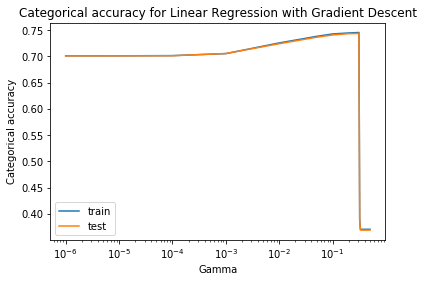

In [115]:
plt.plot(gammas[:], accuracies_train[:], label="train")
plt.plot(gammas[:], accuracies_test[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

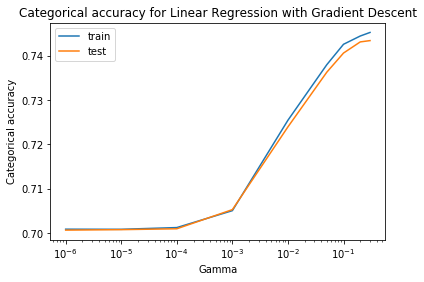

In [116]:
plt.plot(gammas[:9], accuracies_train[:9], label="train")
plt.plot(gammas[:9], accuracies_test[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

### Least Squares GD with non-standardized data

In [133]:
gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result_2 = []
accuracies_train_2 = []
accuracies_test_2 = []
for gamma in gammas:
    weights_LSGD1 = least_squares_GD(y_train_ns, x_train_ns, np.zeros(31), 100, gamma)[1]
    cat_accuracy_train, f1_score_train = metrics(y_train_ns, predict_labels(weights_LSGD1, x_train_ns))
    cat_accuracy_test, f1_score_test = metrics(y_test_ns, predict_labels(weights_LSGD1, x_test_ns))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_2.append(weights_LSGD1)
    accuracies_train_2.append(cat_accuracy_train)
    accuracies_test_2.append(cat_accuracy_test)
    
print(accuracies_train_2)
print(accuracies_test_2)

Gamma: 1e-07 || Categorical accuracy train :  0.65668  || f1_score train:  0.0
Gamma: 1e-07 || Categorical accuracy test :  0.6582741170925196  || f1_score test:  0.0
Gamma: 1e-06 || Categorical accuracy train :  0.66599  || f1_score train:  0.02449624654286843
Gamma: 1e-06 || Categorical accuracy test :  0.6669453313293193  || f1_score test:  0.023779812643900382
Gamma: 1e-05 || Categorical accuracy train :  0.34332  || f1_score train:  0.5111514754488878
Gamma: 1e-05 || Categorical accuracy test :  0.34172588290748035  || f1_score test:  0.5093825605673947
Gamma: 0.0001 || Categorical accuracy train :  0.34332  || f1_score train:  0.5111514754488878
Gamma: 0.0001 || Categorical accuracy test :  0.34172588290748035  || f1_score test:  0.5093825605673947
Gamma: 0.001 || Categorical accuracy train :  0.34332  || f1_score train:  0.5111514754488878
Gamma: 0.001 || Categorical accuracy test :  0.34172588290748035  || f1_score test:  0.5093825605673947
Gamma: 0.01 || Categorical accuracy t

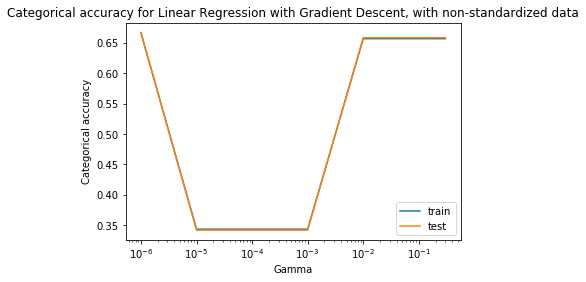

In [113]:
plt.plot(gammas[:9], accuracies_train_2[:9], label="train")
plt.plot(gammas[:9], accuracies_test_2[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent, with non-standardized data")
plt.legend()
plt.show()

## Linear Regression with Stochastic Gradient Descent

In [122]:
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result_3 = []
accuracies_train_3 = []
accuracies_test_3 = []
for gamma in gammas:
    weights_LSGD1 = least_squares_SGD(y_train, x_train, np.zeros(31), 100, gamma)[1]
    cat_accuracy_train, f1_score_train = metrics(y_train, predict_labels(weights_LSGD1, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test, predict_labels(weights_LSGD1, x_test))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_3.append(weights_LSGD1)
    accuracies_train_3.append(cat_accuracy_train)
    accuracies_test_3.append(cat_accuracy_test)
    
print(accuracies_train_3)
print(accuracies_test_3)

Gamma: 1e-06 || Categorical accuracy train :  0.667395  || f1_score train:  0.3312195447566918
Gamma: 1e-06 || Categorical accuracy test :  0.6672566056865378  || f1_score test:  0.3301006920723557
Gamma: 1e-05 || Categorical accuracy train :  0.665605  || f1_score train:  0.2997534642523166
Gamma: 1e-05 || Categorical accuracy test :  0.6650865787390721  || f1_score test:  0.29775412727369066
Gamma: 0.0001 || Categorical accuracy train :  0.690805  || f1_score train:  0.34997793095482654
Gamma: 0.0001 || Categorical accuracy test :  0.6927455287661974  || f1_score test:  0.3486415038919078
Gamma: 0.001 || Categorical accuracy train :  0.704125  || f1_score train:  0.30049030854598446
Gamma: 0.001 || Categorical accuracy test :  0.7033555375708149  || f1_score test:  0.2986427393363495
Gamma: 0.01 || Categorical accuracy train :  0.70771  || f1_score train:  0.27863702479623365
Gamma: 0.01 || Categorical accuracy test :  0.7055166709652173  || f1_score test:  0.2740550289727158
Gamma: 

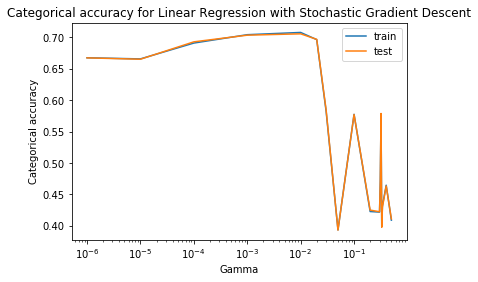

In [123]:
plt.plot(gammas[:], accuracies_train_3[:], label="train")
plt.plot(gammas[:], accuracies_test_3[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Stochastic Gradient Descent")
plt.legend()
plt.show()

## Least Squares

In [125]:
weights_LS = least_squares(y_train, x_train)[1]
cat_accuracy_train, f1_score_train = metrics(y_train, predict_labels(weights_LS, x_train))
cat_accuracy_test, f1_score_test = metrics(y_test, predict_labels(weights_LS, x_test))


print("Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
print("Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)

Categorical accuracy train :  0.745255  || f1_score train:  0.29218932789111
Categorical accuracy test :  0.7438212040092137  || f1_score test:  0.2880090136041475


## Ridge regression

In [161]:
lambdas = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
lambdas =  np.logspace(-6, 12, 40)
weights_result_4 = []
accuracies_train_4 = []
accuracies_test_4 = []
for lambda_ in lambdas:
    weights_RR = ridge_regression(y_train, x_train, lambda_)[1]
    cat_accuracy_train, f1_score_train = metrics(y_train, predict_labels(weights_RR, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test, predict_labels(weights_RR, x_test))
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_4.append(weights_RR)
    accuracies_train_4.append(cat_accuracy_train)
    accuracies_test_4.append(cat_accuracy_test)
    
print(accuracies_train_4)
print(accuracies_test_4)

Lambda: 1e-06 || Categorical accuracy train :  0.745275  || f1_score train:  0.29221849356593316
Lambda: 1e-06 || Categorical accuracy test :  0.7438212040092137  || f1_score test:  0.2880090136041475
Lambda: 2.894266124716752e-06 || Categorical accuracy train :  0.745275  || f1_score train:  0.29221849356593316
Lambda: 2.894266124716752e-06 || Categorical accuracy test :  0.7438300975622771  || f1_score test:  0.2880220466206855
Lambda: 8.376776400682924e-06 || Categorical accuracy train :  0.74529  || f1_score train:  0.29221849356593316
Lambda: 8.376776400682924e-06 || Categorical accuracy test :  0.7438389911153405  || f1_score test:  0.2880220466206855
Lambda: 2.424462017082331e-05 || Categorical accuracy train :  0.74528  || f1_score train:  0.29221849356593316
Lambda: 2.424462017082331e-05 || Categorical accuracy test :  0.7438300975622771  || f1_score test:  0.28803507943878986
Lambda: 7.017038286703837e-05 || Categorical accuracy train :  0.745235  || f1_score train:  0.292225

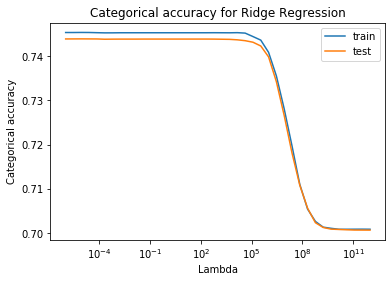

In [162]:
plt.plot(lambdas[:], accuracies_train_4[:], label="train")
plt.plot(lambdas[:], accuracies_test_4[:], label="test")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Ridge Regression")
plt.legend()
plt.show()

In [163]:
print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_4)], ", train accuracy: ", accuracies_train_4[np.argmax(accuracies_test_4)], ", test accuracy: ", accuracies_test_4[np.argmax(accuracies_test_4)])

Best performance: lambda  8.376776400682924e-06 , train accuracy:  0.74529 , test accuracy:  0.7438389911153405


## Logistic regression

In [171]:
y_train_log = np.copy(y_train)
y_train_log = np.where(y_train_log==-1, 0, y_train_log)

y_test_log = np.copy(y_test)
y_test_log = np.where(y_test_log==-1, 0, y_test_log)

gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result_5 = []Las
accuracies_train_5 = []
accuracies_test_5 = []
for gamma in gammas:
    weights_LR = logistic_regression(y_train_log, x_train, np.zeros(31), 10000, gamma)[1]
    cat_accuracy_train, f1_score_train = metrics(y_train_log, predict_labels(weights_LR, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test_log, predict_labels(weights_LR, x_test))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_5.append(weights_LR)
    accuracies_train_5.append(cat_accuracy_train)
    accuracies_test_5.append(cat_accuracy_test)
    
print(accuracies_train_5)
print(accuracies_test_5)

The loss for step 0 is 138629.4166448951.
The loss for step 1000 is 138626.5698187715.
The loss for step 2000 is 138623.75577457578.
The loss for step 3000 is 138621.16402937652.
The loss for step 4000 is 138618.06076069808.
The loss for step 5000 is 138615.1905828241.
The loss for step 6000 is 138612.0306967711.
The loss for step 7000 is 138609.09684004454.
The loss for step 8000 is 138605.99468280113.
The loss for step 9000 is 138602.97128586506.
Gamma: 1e-07 || Categorical accuracy train :  0.698965  || f1_score train:  0.30476150113369077
Gamma: 1e-07 || Categorical accuracy test :  0.6986953157656015  || f1_score test:  0.30304630964149076
The loss for step 0 is 138629.38954032148.
The loss for step 1000 is 138603.7133370153.
The loss for step 2000 is 138573.01321217854.
The loss for step 3000 is 138544.8058712829.
The loss for step 4000 is 138514.3802728582.
The loss for step 5000 is 138483.5559480535.
The loss for step 6000 is 138453.44656117546.
The loss for step 7000 is 138425

In [174]:
print("Best performance: gamma ", gammas[np.argmax(accuracies_test_5)], ", train accuracy: ", accuracies_train_5[np.argmax(accuracies_test_5)], ", test accuracy: ", accuracies_test_5[np.argmax(accuracies_test_5)])

Best performance: gamma  0.01 , train accuracy:  0.7457 , test accuracy:  0.7446127302318549


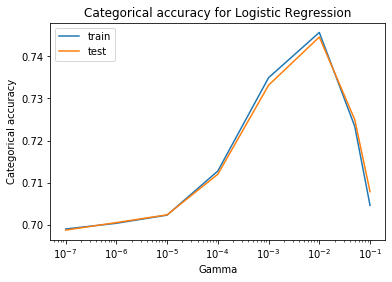

In [173]:
plt.plot(gammas[:8], accuracies_train_5[:8], label="train")
plt.plot(gammas[:8], accuracies_test_5[:8], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Logistic Regression")
plt.legend()
plt.show()

## Regularized logistic regression

In [193]:
gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
lambdas = lambdas =  np.logspace(-4, 4, 5)
weights_result_6 = []
accuracies_train_6 = []
accuracies_test_6 = []
for lambda_ in lambdas:
    accuracy_train = []
    accuracy_test = []
    weights = []
    for gamma in gammas:
        weights_RLR = reg_logistic_regression(y_train_log, x_train, lambda_, np.zeros(31), 10000, gamma)[1]
        cat_accuracy_train, f1_score_train = metrics(y_train_log, predict_labels(weights_RLR, x_train))
        cat_accuracy_test, f1_score_test = metrics(y_test_log, predict_labels(weights_RLR, x_test))

        print("Lambda: " + str(lambda_) + " Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
        print("Lambda: " + str(lambda_) + " Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
        weights.append(weights_RLR)
        accuracy_train.append(cat_accuracy_train)
        accuracy_test.append(cat_accuracy_test)
    weights_result_6.append(weights)
    accuracies_train_6.append(accuracy_train)
    accuracies_test_6.append(accuracy_test)

print(accuracies_train_6)
print(accuracies_test_6)

IndexError: list index out of range

In [191]:
best_index = np.unravel_index(np.argmax(np.matrix(accuracies_test_6), axis=None), np.matrix(accuracies_test_6).shape)
print(np.argmax(accuracies_test_6))
print("Best performance: lambda ", lambdas[best_index[0]], ", gamma: ", gammas[best_index[1]], ", train accuracy: ", accuracies_train_6[best_index], ", test accuracy: ", accuracies_test_6[best_index])

0


TypeError: list indices must be integers or slices, not tuple

In [194]:
weights_result_6

[]